# MRI Datasets Analysis

This notebook analyzes multiple MRI dataset metadata files to extract information about:
- Number of participants
- Age distribution
- Sex distribution
- Dementia prevalence (where available)
- MRI modalities

The analysis combines data from multiple neuroimaging datasets to provide a comprehensive overview.

In [97]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

## Data Loading

First, we'll load all the dataset files using appropriate methods based on file extensions.

In [98]:
# Function to read files based on extension
def read_file(filename):
    """Read file based on extension and return dataframe"""
    ext = filename.split('.')[-1].lower()
    
    if ext == 'tsv':
        return pd.read_csv(filename, sep='\t')
    elif ext == 'csv':
        return pd.read_csv(filename)
    elif ext in ['xls', 'xlsx']:
        return pd.read_excel(filename)
    else:
        print(f"Unsupported file format: {ext}")
        return None

# Read all files
file_names = [
    "IXI.xls",
    "openbhb_train_participants.tsv",
    "openbhb_val_participants.tsv",
    "oasis2_longitudinal_demographics.xlsx",
    "OASIS3_demographics.csv",
    "bold_var_participants.tsv",
    "camcan_participants.tsv",
    "oasis1_cross-sectional-5708aa0a98d82080.xlsx",
    "dallas_participants.tsv",
    "narr_participants.tsv",
    "npc_participants.tsv",
    "mpi_leizig_participants.tsv",
    "SALD_sub_information.xlsx"
]

# Dictionary to store dataframes
dfs = {}
base_path = 'C:/Projects/thesis_project/Data/all_demographics/'
for file in file_names:
    df_name = file.split('.')[0]
    dfs[df_name] = read_file(base_path + file)
    print(f"Loaded {file}: {dfs[df_name].shape[0]} rows, {dfs[df_name].shape[1]} columns")
for key in dfs.keys():
    print(f"Columns in {key}: {dfs[key].columns.tolist()}")

Loaded IXI.xls: 619 rows, 12 columns
Loaded openbhb_train_participants.tsv: 3227 rows, 12 columns
Loaded openbhb_val_participants.tsv: 757 rows, 13 columns
Loaded oasis2_longitudinal_demographics.xlsx: 373 rows, 15 columns
Loaded OASIS3_demographics.csv: 1378 rows, 19 columns
Loaded bold_var_participants.tsv: 158 rows, 11 columns
Loaded camcan_participants.tsv: 653 rows, 6 columns
Loaded oasis1_cross-sectional-5708aa0a98d82080.xlsx: 436 rows, 12 columns
Loaded dallas_participants.tsv: 464 rows, 36 columns
Loaded narr_participants.tsv: 345 rows, 6 columns
Loaded npc_participants.tsv: 66 rows, 37 columns
Loaded mpi_leizig_participants.tsv: 318 rows, 3 columns
Loaded SALD_sub_information.xlsx: 494 rows, 7 columns
Columns in IXI: ['IXI_ID', 'SEX_ID (1=m, 2=f)', 'HEIGHT', 'WEIGHT', 'ETHNIC_ID', 'MARITAL_ID', 'OCCUPATION_ID', 'QUALIFICATION_ID', 'DOB', 'DATE_AVAILABLE', 'STUDY_DATE', 'AGE']
Columns in openbhb_train_participants: ['participant_id', 'study', 'sex', 'age', 'site', 'diagnosis', 

## Helper Functions

These functions extract relevant information from each dataset, handling different column naming conventions.

In [99]:
def get_unique_participants(df):
    """Extract unique participant count from dataframe"""
    id_patterns = ['oasisid', 'participant_id', 'subject', 'id', 'oasis']
    
    for pattern in id_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        if matching_cols:
            return df[matching_cols[0]].nunique()
    
    return df.shape[0]

In [100]:
def get_age_info(df):
    """Extract age statistics from dataframe"""
    age_patterns = ['age', 'agec', 'agem']
    age_cols = []
    
    for pattern in age_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        age_cols.extend(matching_cols)
    
    if not age_cols:
        return {'mean': np.nan, 'min': np.nan, 'max': np.nan}
    
    for col in age_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            valid_ages = df[col].dropna()
            if not valid_ages.empty:
                return {
                    'mean': valid_ages.mean(),
                    'min': valid_ages.min(),
                    'max': valid_ages.max()
                }
        else:
            try:
                numeric_ages = pd.to_numeric(df[col], errors='coerce')
                valid_ages = numeric_ages.dropna()
                if not valid_ages.empty:
                    return {
                        'mean': valid_ages.mean(),
                        'min': valid_ages.min(),
                        'max': valid_ages.max()
                    }
            except:
                continue
    
    return {'mean': np.nan, 'min': np.nan, 'max': np.nan}

In [101]:
def get_sex_distribution(df):
    """Extract sex distribution from dataframe"""
    sex_patterns = ['sex', 'gender', 'm/f']
    sex_cols = []
    
    for pattern in sex_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        sex_cols.extend(matching_cols)
    
    if not sex_cols:
        return {'male': np.nan, 'female': np.nan, 'unknown': np.nan}
    
    sex_col = sex_cols[0]
    sex_values = df[sex_col].fillna('Unknown').astype(str).str.lower()
    
    male_count = sum(sex_values.isin(['m', 'male', '1', 'boy', 'man']) | 
                     sex_values.str.contains('^m$', regex=True))
    
    female_count = sum(sex_values.isin(['f', 'female', '2', 'girl', 'woman']) | 
                       sex_values.str.contains('^f$', regex=True))
    
    unknown_count = len(sex_values) - male_count - female_count
    
    total = len(sex_values)
    return {
        'male': (male_count / total) * 100 if total > 0 else np.nan,
        'female': (female_count / total) * 100 if total > 0 else np.nan,
        'unknown': (unknown_count / total) * 100 if total > 0 else np.nan
    }

In [102]:
def get_dementia_info(df):
    """Extract dementia prevalence from dataframe"""
    dementia_patterns = ['dement', 'cdr', 'diagnosis', 'group', 'mmse']
    dementia_cols = []
    
    for pattern in dementia_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        dementia_cols.extend(matching_cols)
    
    if not dementia_cols:
        return np.nan
    
    for col in dementia_cols:
        col_lower = col.lower()
        
        # CDR (Clinical Dementia Rating) approach
        if 'cdr' in col_lower:
            if pd.api.types.is_numeric_dtype(df[col]):
                dementia_count = sum(df[col] > 0)
                total = sum(~df[col].isna())
            else:
                try:
                    numeric_vals = pd.to_numeric(df[col], errors='coerce')
                    dementia_count = sum(numeric_vals > 0)
                    total = sum(~numeric_vals.isna())
                except:
                    continue
                    
        # Diagnosis or Group approach
        elif 'diagnosis' in col_lower or 'group' in col_lower:
            values = df[col].fillna('Unknown').astype(str).str.lower()
            dementia_count = sum(values.str.contains('dement|alzheimer|ad|mci', regex=True, na=False))
            total = sum(values != 'unknown')
            
        # MMSE approach
        elif 'mmse' in col_lower:
            if pd.api.types.is_numeric_dtype(df[col]):
                mmse_vals = df[col].dropna()
                dementia_count = sum(mmse_vals < 24)
                total = len(mmse_vals)
            else:
                try:
                    mmse_numeric = pd.to_numeric(df[col], errors='coerce')
                    mmse_vals = mmse_numeric.dropna()
                    dementia_count = sum(mmse_vals < 24)
                    total = len(mmse_vals)
                except:
                    continue
        else:
            continue
            
        if 'dementia_count' in locals() and 'total' in locals() and total > 0:
            return (dementia_count / total) * 100
            
    return np.nan

In [103]:
def get_mri_modalities(df):
    """Detect MRI modalities available in the dataset"""
    modality_map = {
        'T1': ['t1', 't1w', 't1-'],
        'T2': ['t2', 't2w', 't2-'],
        'FLAIR': ['flair'],
        'DWI': ['dwi', 'dti', 'diffusion'],
        'fMRI': ['fmri', 'func', 'bold', 'rest'],
        'PET': ['pet', 'amyloid', 'tau']
    }
    
    found_modalities = []
    
    # Check column names for modality indicators
    for modality, keywords in modality_map.items():
        for keyword in keywords:
            if any(keyword in col.lower() for col in df.columns):
                found_modalities.append(modality)
                break
    
    return ', '.join(found_modalities) if found_modalities else 'Unknown'

## Dataset Summary Creation

Create a summary table with key statistics for each dataset.

In [104]:
def create_dataset_summary(dfs):
    """Create summary statistics for all datasets"""
    summary_data = []
    
    for name, df in dfs.items():
        participants = get_unique_participants(df)
        age_info = get_age_info(df)
        sex_dist = get_sex_distribution(df)
        dementia_percent = get_dementia_info(df)
        modalities = get_mri_modalities(df)
        
        summary_data.append({
            'Dataset': name,
            'Participants': participants,
            'Mean Age': age_info['mean'],
            'Min Age': age_info['min'],
            'Max Age': age_info['max'],
            'Male %': sex_dist['male'],
            'Female %': sex_dist['female'],
            'Unknown Sex %': sex_dist['unknown'],
            'Dementia %': dementia_percent,
            'MRI Modalities': modalities
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Add total/average row
    total_row = {
        'Dataset': 'TOTAL',
        'Participants': summary_df['Participants'].sum(),
        'Mean Age': summary_df['Mean Age'].mean(),
        'Min Age': summary_df['Min Age'].min(),
        'Max Age': summary_df['Max Age'].max(),
        'Male %': summary_df['Male %'].mean(),
        'Female %': summary_df['Female %'].mean(),
        'Unknown Sex %': summary_df['Unknown Sex %'].mean(),
        'Dementia %': summary_df['Dementia %'].mean(),
        'MRI Modalities': 'Combined'
    }
    
    summary_df = pd.concat([summary_df, pd.DataFrame([total_row])], ignore_index=True)
    return summary_df

In [105]:
# Generate summary
dataset_summary = create_dataset_summary(dfs)
print("\nDataset Summary:")
#print(dataset_summary)
dataset_summary


Dataset Summary:


,Dataset,Participants,Mean Age,Min Age,Max Age,Male %,Female %,Unknown Sex %,Dementia %,MRI Modalities
0,IXI,593,49.416235,19.980835,86.318960,44.749596,55.250404,0.000000,NaN,Unknown
1,openbhb_train_participants,3227,25.189897,6.000000,86.198494,51.719864,48.280136,0.000000,0.000000,Unknown
2,openbhb_val_participants,757,23.782039,5.900000,88.000000,55.217966,44.782034,0.000000,0.000000,Unknown
3,oasis2_longitudinal_demographics,150,77.013405,60.000000,98.000000,42.895442,57.104558,0.000000,44.772118,Unknown
4,OASIS3_demographics,1378,69.055993,42.498600,95.632900,45.137881,54.862119,0.000000,NaN,Unknown
5,bold_var_participants,158,49.278481,20.000000,86.000000,37.341772,62.658228,0.000000,NaN,"T1, T2, DWI, fMRI"
6,camcan_participants,653,54.310873,18.000000,88.000000,49.464012,50.535988,0.000000,NaN,Unknown
7,oasis1_cross-sectional-5708aa0a98d82080,436,51.357798,18.000000,96.000000,38.532110,61.467890,0.000000,42.553191,Unknown
8,dallas_participants,464,58.312500,21.000000,89.000000,38.146552,61.853448,0.000000,0.000000,PET
9,narr_participants,345,22.009804,18.000000,45.000000,14.782609,16.231884,68.985507,NaN,Unknown


## Visualizations

Create visualizations to better understand the datasets.

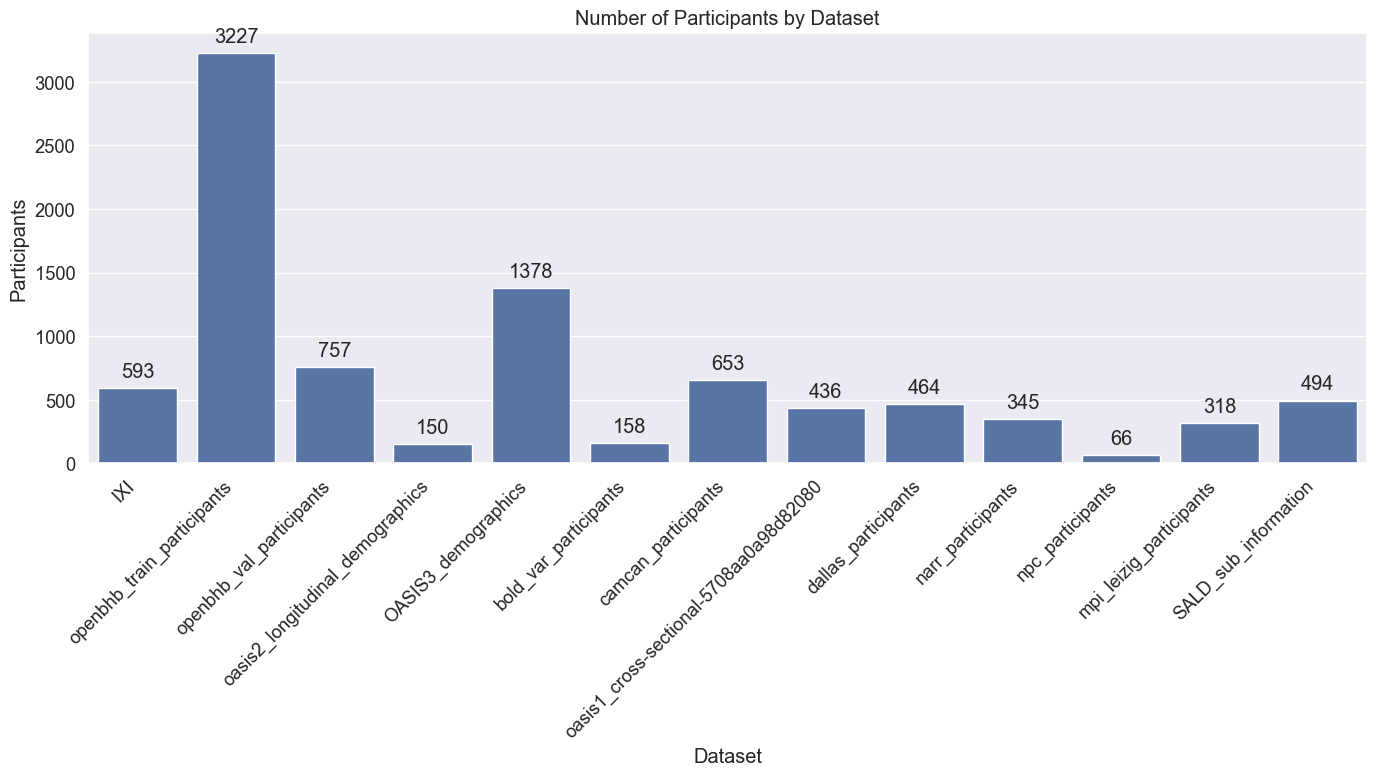

In [106]:
# 1. Number of participants per dataset
plt.figure(figsize=(14, 8))
plot_data = dataset_summary[dataset_summary['Dataset'] != 'TOTAL']
ax = sns.barplot(x='Dataset', y='Participants', data=plot_data)
plt.title('Number of Participants by Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', 
                xytext = (0, 5), textcoords = 'offset points')

plt.savefig('participants_by_dataset.png')
plt.show()

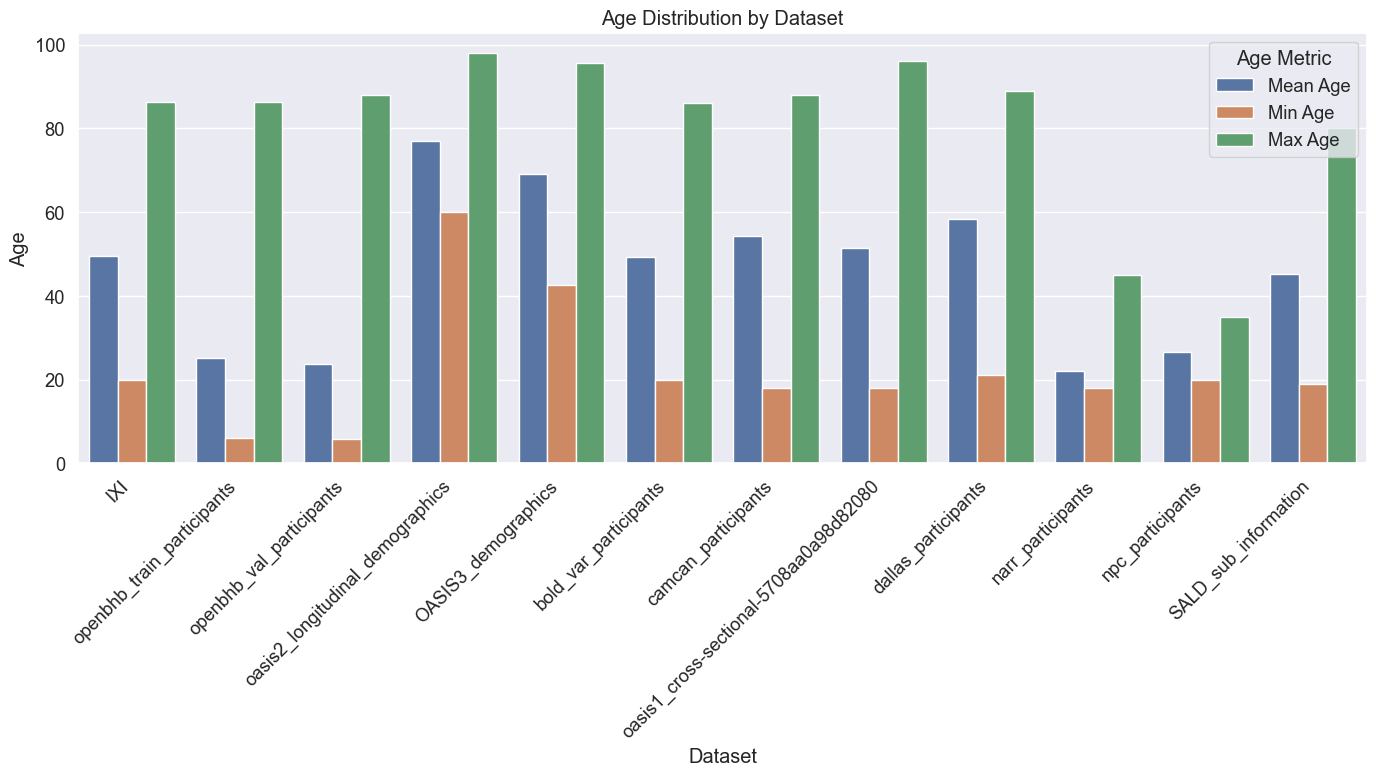

In [107]:
# 2. Age distribution by dataset
plt.figure(figsize=(14, 8))
age_data = plot_data[['Dataset', 'Mean Age', 'Min Age', 'Max Age']].dropna()
age_data = age_data.melt(id_vars=['Dataset'], var_name='Age Metric', value_name='Age')
sns.barplot(x='Dataset', y='Age', hue='Age Metric', data=age_data)
plt.title('Age Distribution by Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('age_by_dataset.png')
plt.show()

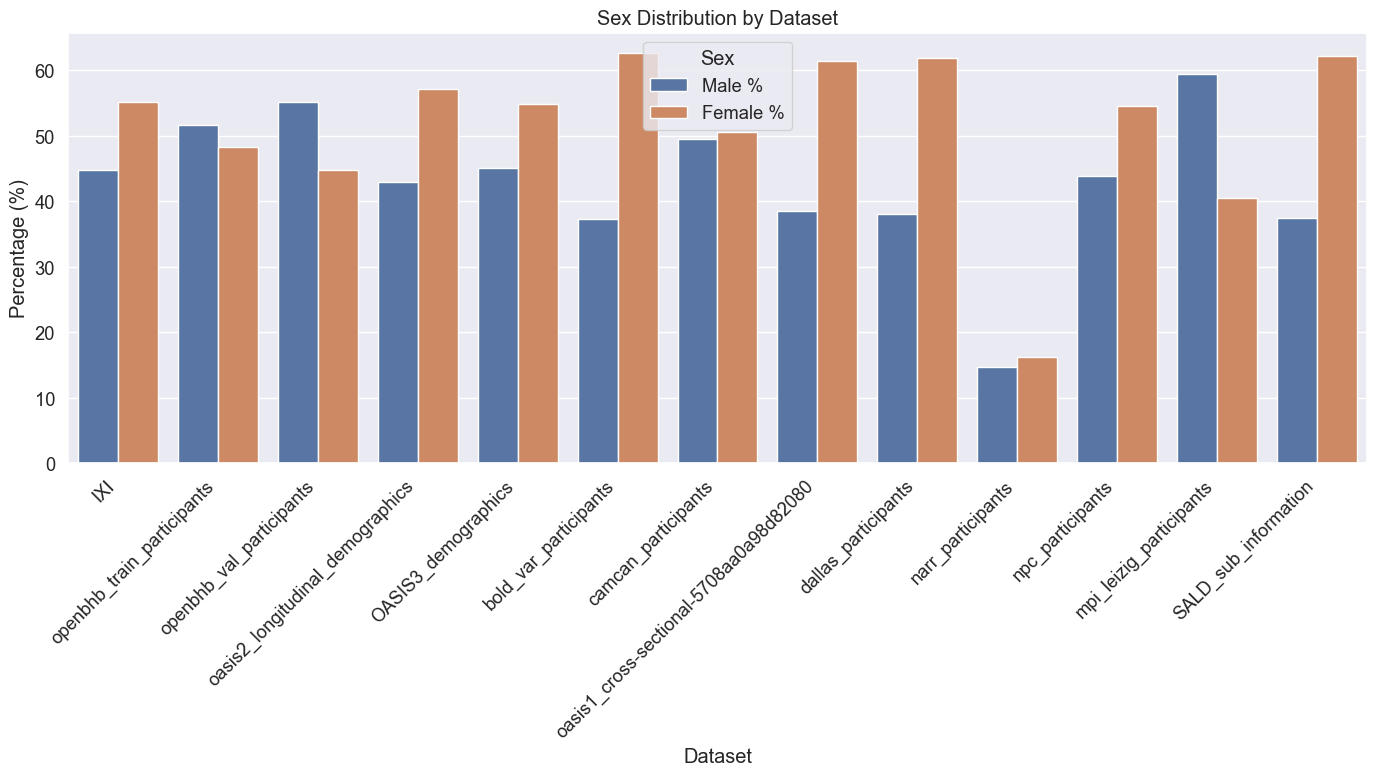

In [108]:
# 3. Sex distribution by dataset
plt.figure(figsize=(14, 8))
sex_data = plot_data[['Dataset', 'Male %', 'Female %']].dropna()
sex_data = sex_data.melt(id_vars=['Dataset'], var_name='Sex', value_name='Percentage')
sns.barplot(x='Dataset', y='Percentage', hue='Sex', data=sex_data)
plt.title('Sex Distribution by Dataset')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.savefig('sex_by_dataset.png')
plt.show()

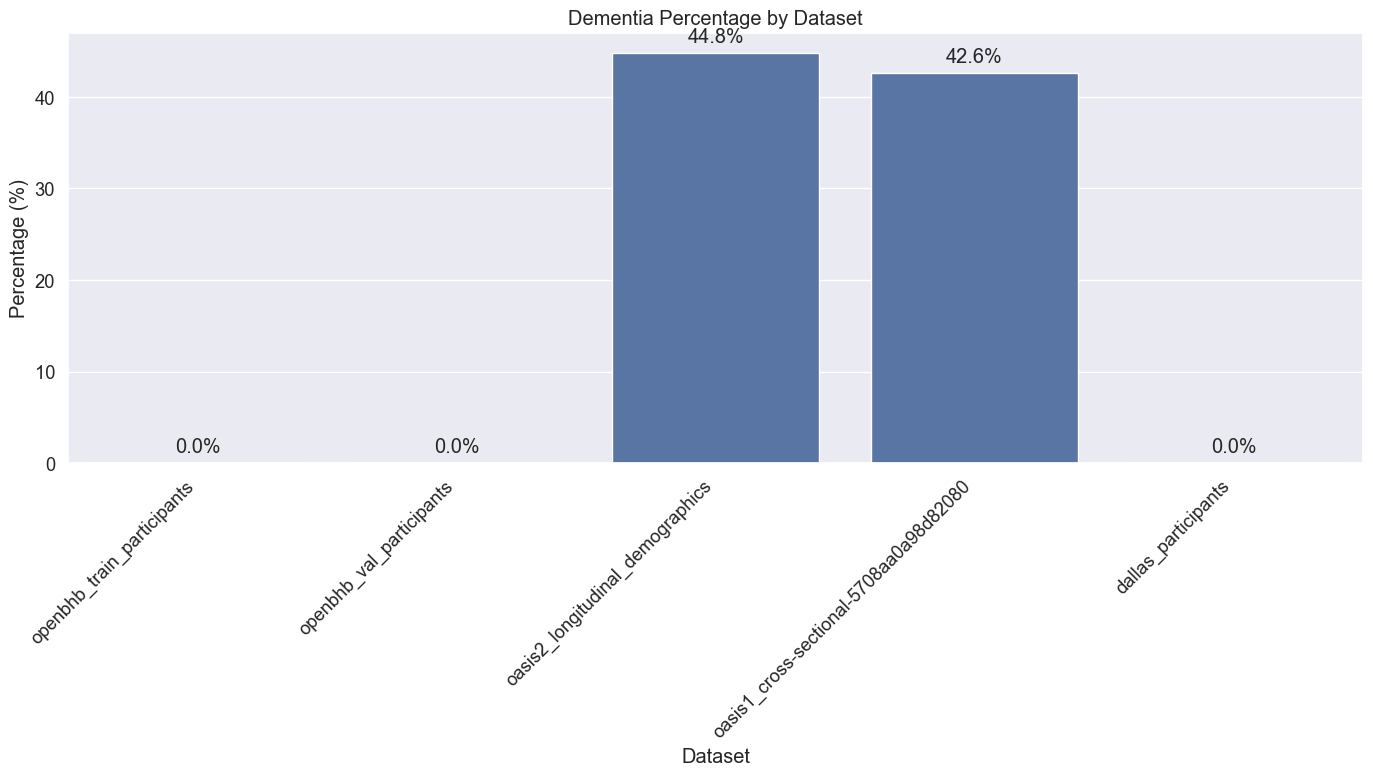

In [109]:
# 4. Dementia percentage by dataset (if available)
dementia_data = plot_data[['Dataset', 'Dementia %']].dropna()
if not dementia_data.empty:
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Dataset', y='Dementia %', data=dementia_data)
    plt.title('Dementia Percentage by Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage (%)')
    
    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.savefig('dementia_by_dataset.png')
    plt.show()

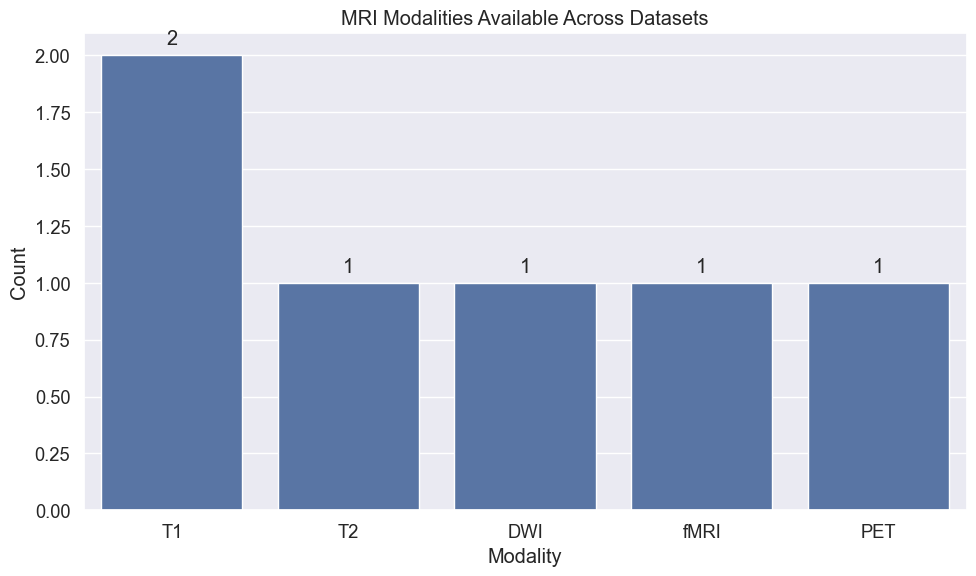

In [110]:
# 5. MRI modalities distribution
modality_data = defaultdict(int)

for idx, row in dataset_summary.iterrows():
    if row['Dataset'] != 'TOTAL' and row['MRI Modalities'] != 'Unknown':
        for modality in row['MRI Modalities'].split(', '):
            modality_data[modality] += 1

if modality_data:
    plt.figure(figsize=(10, 6))
    modality_df = pd.DataFrame({
        'Modality': list(modality_data.keys()),
        'Count': list(modality_data.values())
    })
    ax = sns.barplot(x='Modality', y='Count', data=modality_df)
    
    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), textcoords = 'offset points')
    
    plt.title('MRI Modalities Available Across Datasets')
    plt.tight_layout()
    plt.savefig('modality_distribution.png')
    plt.show()

<Figure size 1400x800 with 0 Axes>

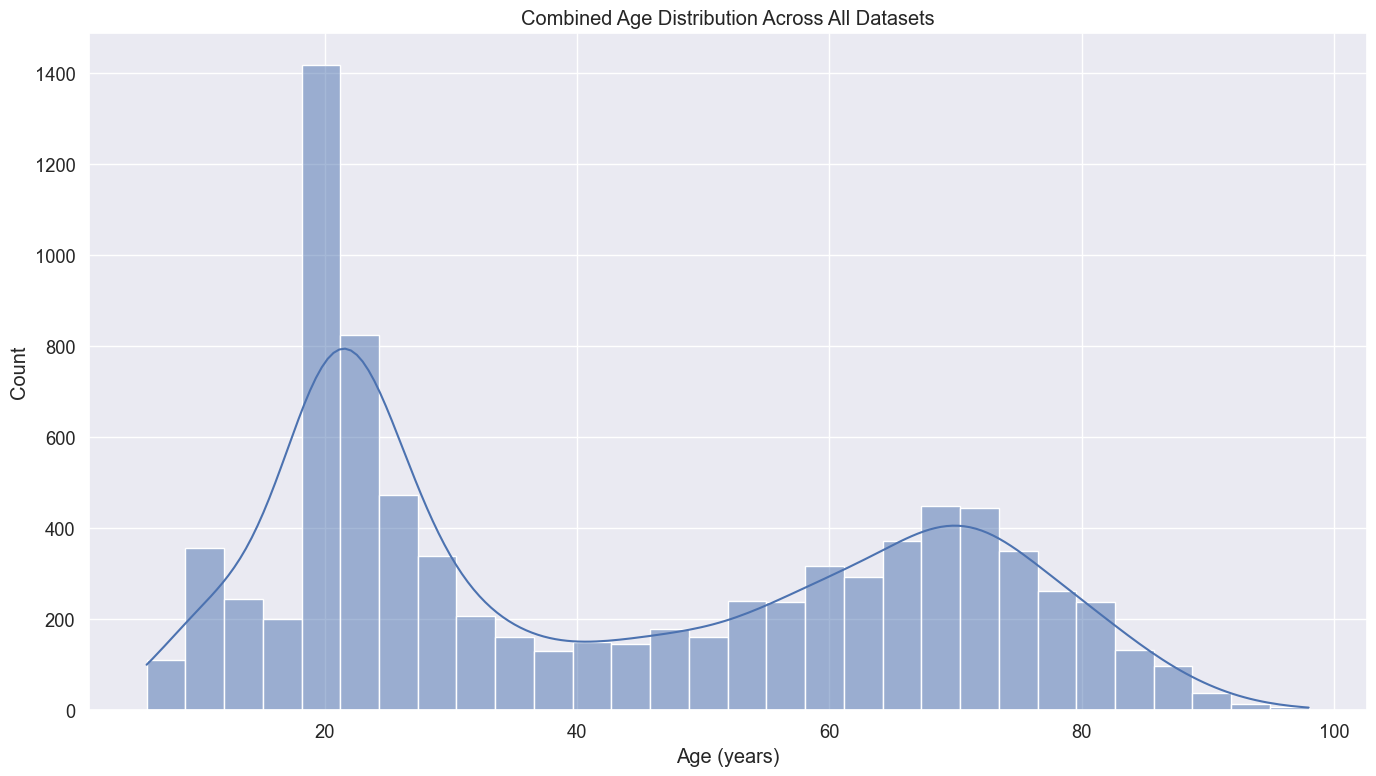

In [111]:
# Age distribution analysis for all datasets combined
plt.figure(figsize=(14, 8))
all_ages = []
dataset_labels = []

for name, df in dfs.items():
    age_cols = [col for col in df.columns if 'age' in col.lower()]
    if age_cols:
        for col in age_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                valid_ages = df[col].dropna()
                if not valid_ages.empty and valid_ages.max() < 120:  # Filter out unreasonable ages
                    all_ages.extend(valid_ages)
                    dataset_labels.extend([name] * len(valid_ages))
                break

if all_ages:
    age_df = pd.DataFrame({'Age': all_ages, 'Dataset': dataset_labels})
    plt.figure(figsize=(14, 8))
    sns.histplot(data=age_df, x='Age', kde=True, bins=30)
    plt.title('Combined Age Distribution Across All Datasets')
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('combined_age_distribution.png')
    plt.show()

## Overall Summary

Key findings from the analysis of all datasets.

In [112]:
# Overall summary
print("\nOverall Summary:")
total_participants = dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Participants'].values[0]
print(f"Total participants across all datasets: {int(total_participants)}")

age_range = f"{dataset_summary['Min Age'].min():.1f} - {dataset_summary['Max Age'].max():.1f}"
print(f"Overall age range: {age_range} years")

sex_ratio = f"{dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Male %'].values[0]:.1f}% male, " \
           f"{dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Female %'].values[0]:.1f}% female"
print(f"Overall sex distribution: {sex_ratio}")

if not dataset_summary['Dementia %'].isna().all():
    dem_percent = dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Dementia %'].values[0]
    print(f"Overall dementia percentage: {dem_percent:.1f}%")

# List all available modalities
all_modalities = set()
for idx, row in dataset_summary.iterrows():
    if row['MRI Modalities'] != 'Unknown' and row['Dataset'] != 'TOTAL':
        modalities = row['MRI Modalities'].split(', ')
        all_modalities.update(modalities)

print(f"MRI modalities available across datasets: {', '.join(sorted(all_modalities))}")


Overall Summary:
Total participants across all datasets: 9039
Overall age range: 5.9 - 98.0 years
Overall sex distribution: 43.0% male, 51.6% female
Overall dementia percentage: 17.5%
MRI modalities available across datasets: DWI, PET, T1, T2, fMRI
